In a recent paper by Twyman et al. [(Chem. Mater. 2022, 34, 2545-2552)](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.1c02644), the environmental stability of crystals is investigated by introducing a greedy heuristic algorithm to determine the oxidation reactions that can occur. In the 2-part notebook we will show that:
1. The original implementation, kindly provided by Twyman et al. through [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg), is a "lazy" version of the greedy algorithm as described in their manuscript.
2. The environmental stability problem can be solved exactly using linear programming, while greedy algorithms can only give approximations.


The key of environmental stability is to find oxidation products, this can be described as the following:

> Given an oxygen-free compound $C$ and a set of oxides $O_1, O_2, ..., O_n$, the oxidation reaction of $C$ is defined as
> $C + y\mathrm{O}_2 = x_1 O_1 + x_2 O_2 + ... + x_n O_n $ (the unitalicized $\mathrm{O}_2$ represents gas phase oxygen)
> where $y$ is arbitrary and elemental conservation is observed.
> Find the solution $X^{s} = {x^s_1, x^s_2, ..., x^s_n}$ > such that the reaction enthalpy of this reaction is minimized.


In [1]:
# required import
import inspect
from rich.console import Console
from rich.syntax import Syntax
from pqdm.processes import pqdm
import matplotlib.pyplot as plt
from whygreedy import *

## Part 1. Diligent greedy

[Twyman2022](https://pubs.acs.org/doi/10.1021/acs.chemmater.1c02644) proposed a ranking parameter for an oxide defined as its contribution the reaction enthalpy. We implemented this function in `whygreedy.algo`.

In [2]:
# printout source with python syntax
console = Console(width=120)
syntax = Syntax(inspect.getsource(calculate_ranking_parameter), "python")
console.print(syntax)

def calculate_ranking_parameter(oxide: Compound, original: Compound, for_oxide=True) -> float:                          
    """                                                                                                                 
    this is the ranking parameter as defined in the paper, a smaller number indicated the oxide is more favored,        
    the one with the smallest ranking parameter will be used to "consume" the original compound                         
    """                                                                                                                 
    # if the oxide has an element with > 0 composition,                                                                 
    # and this element is not present or is of 0 composition in the                                                     
    # original compound,                                                                                                
    # then the ranking parameter is inf because it is impossible to consume the original compound                       
    # with this oxide (and the solution for this oxide is 0)                                                            
    if for_oxide:                                                                                                       
        for e in oxide.elements_exclude_oxygen:                                                                         
            oxide_composition = oxide.normalized_formula[e]                                                             
            original_composition = original.normalized_formula[e]                                                       
            if not is_close_to_zero(oxide_composition) and is_close_to_zero(original_composition):                      
                return np.inf                                                                                           
        p = 0                                                                                                           
        for element in oxide.elements:                                                                                  
            if element == "O":                                                                                          
                continue                                                                                                
            c = oxide.normalized_formula[element] / original.normalized_formula[element]                                
            p += c                                                                                                      
        rp = oxide.formation_energy_per_atom / p                                                                        
        return rp                                                                                                       
    else:                                                                                                               
        for e in oxide.elements:                                                                                        
            oxide_composition = oxide.normalized_formula[e]                                                             
            original_composition = original.normalized_formula[e]                                                       
            if not is_close_to_zero(oxide_composition) and is_close_to_zero(original_composition):                      
                return np.inf                                                                                           
        p = 0                                                                                                           
        for element in oxide.elements:                                                                                  
            c = oxide.normalized_formula[element] / original.normalized_formula[element]                                
       

Now we implement the greedy algorithm by ourselves. We will use an argument `diligent_greedy` to show why the implementation found on
[zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg) is a lazy version of the greedy algorithm.

In [3]:
syntax = Syntax(inspect.getsource(find_greedy), "python")
console.print(syntax)

def find_greedy(                                                                                                        
        oxides: list[Compound], original: Compound, first_choice: int = 0, diligent_greedy=True, for_oxide=True,        
) -> Tuple[list[float], float]:                                                                                         
    # placeholder for the solution                                                                                      
    solution = []                                                                                                       
    final_enthalpy = 0.0                                                                                                
                                                                                                                        
    # assign an index for oxides                                                                                        
    for ioxi, oxi in enumerate(oxides):                                                                                 
        oxi.properties["index"] = ioxi                                                                                  
                                                                                                                        
    # we will be updating the original compound, better make a deep copy                                                
    updated_original = deepcopy(original)                                                                               
    sorted_oxides = oxides  # no need for deep copy                                                                     
                                                                                                                        
    # init the loop and perform the first greedy ranking                                                                
    counter = 0                                                                                                         
    sorted_oxides = sorted(sorted_oxides,                                                                               
                           key=lambda x: calculate_ranking_parameter(x, updated_original, for_oxide=for_oxide))         
                                                                                                                        
    while len(solution) < len(oxides):                                                                                  
        if diligent_greedy:                                                                                             
            # greedy means to find the best in each iteration                                                           
            # the implementation found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg) does not sort the    
            # oxide list at every iteration (only at initialization), so it is not a greedy algorithm                   
            # this becomes even more problematic considering they used different `first_choice`                         
            sorted_oxides = sorted(sorted_oxides,                                                                       
                                   key=lambda x: calculate_ranking_parameter(x, updated_original, for_oxide=for_oxide)) 
        # we can force the first choice to be something else, but always choose the best starting the 2nd iteration     
        if counter == 0:                                                                                                
            favored_oxide = sorted_oxides[first_choice]                                                                 
            index_to_pop = first_choice                                                                                 
        else:                                                                                                           
       

Finally, we have the implementation we found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg). We wrote a wrapper such that it works with our schema.

In [4]:
syntax = Syntax(inspect.getsource(find_greedy_old), "python")
console.print(syntax)

def find_greedy_old(oxides: list[Compound], original: Compound, first_choice: int = 0, for_oxides=True) -> Tuple[       
    list[float], float]:                                                                                                
    """                                                                                                                 
    This is just a wrapper for the implementation from 10.1021/acs.chemmater.1c02644                                    
    It is identical to `find_greedy` with `diligent_greedy` set to False                                                
    """                                                                                                                 
    stable_oxides = []                                                                                                  
    for ioxide, oxide in enumerate(oxides):                                                                             
        stable_oxide = {                                                                                                
            "nsites": 1,                                                                                                
            # have to make a copy as `find_comp` changes it                                                             
            "unit_cell_formula": {k: v for k, v in oxide.normalized_formula.items()},                                   
            "formation_energy_per_atom": oxide.formation_energy_per_atom,                                               
            "index": ioxide,                                                                                            
            "elements": oxide.elements,                                                                                 
        }                                                                                                               
        stable_oxides.append(stable_oxide)                                                                              
    compound_unit_cell = original.normalized_formula                                                                    
                                                                                                                        
    if for_oxides:                                                                                                      
        solution_oxides, final_enthalpy, delta_enthalpy, _, _, _ = find_comp(stable_oxides, compound_unit_cell,         
                                                                             original.formation_energy_per_atom,        
                                                                             "Oxide", first_choice)                     
    else:                                                                                                               
        solution_oxides, final_enthalpy, delta_enthalpy, _, _, _ = find_comp(stable_oxides, compound_unit_cell,         
                                                                             original.formation_energy_per_atom, "non", 
                                                                             first_choice)                              
                                                                                                                        
    solution = np.zeros(len(oxides))                                                                                    
    for oxide in solution_oxides:                                                                                       
        solution[oxide["index"]] = oxide["ratio"]                                                                       
    return solution.tolist(), delta_enthalpy                                                                            
                                                                                                      

So now we have three different implementations:
- `find_greedy_old` is the one by Twyman et al. we found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg).
- `find_greedy(diligent=False)` is the *lazy* greedy algorithm
- `find_greedy(diligent=True)` is the *diligent* greedy algorithm


### Diligent vs lazy: random oxidation reactions

We will use randomly generated compounds to show that
1. `find_greedy_old` is the *lazy* greedy algorithm
2. The *lazy* greedy algorithm is different from the *diligent* algorithm

In [5]:
# function to calculate data to compare old, lazy and diligent
syntax = Syntax(inspect.getsource(calculate_diligent_vs_lazy_oxides), "python")
console.print(syntax)

# this should take < 30s
seed_max = 1000
random_pairs = [gen_random_data(["A", "B", "C", "D"], 5, seed) for seed in range(seed_max)]
records_random_diligent_vs_lazy = pqdm(random_pairs, calculate_diligent_vs_lazy_oxides, n_jobs=8)

def calculate_diligent_vs_lazy_oxides(pair: list[Compound, list[Compound]]):                                            
    original, oxides = pair                                                                                             
                                                                                                                        
    dh_old_min = np.inf                                                                                                 
    dh_lazy_min = np.inf                                                                                                
    dh_diligent_min = np.inf                                                                                            
                                                                                                                        
    sol_old_min = None                                                                                                  
    sol_lazy_min = None                                                                                                 
    sol_diligent_min = None                                                                                             
                                                                                                                        
    for i in range(len(oxides)):                                                                                        
        sol_old, dh_old = find_greedy_old(oxides, original, first_choice=i, for_oxides=True)                            
        sol_lazy, dh_lazy = find_greedy(oxides, original, first_choice=i, diligent_greedy=False, for_oxide=True)        
        sol_diligent, dh_diligent = find_greedy(oxides, original, first_choice=i, diligent_greedy=True, for_oxide=True) 
                                                                                                                        
        # check elemental conservation                                                                                  
        assert check_solution(sol_old, oxides, original)                                                                
        assert check_solution(sol_lazy, oxides, original)                                                               
        assert check_solution(sol_diligent, oxides, original)                                                           
                                                                                                                        
        # confirm we reproduce the old implementation                                                                   
        assert is_close_to_zero(dh_lazy - dh_old) and np.allclose(sol_lazy, sol_old)                                    
                                                                                                                        
        if dh_old < dh_old_min:                                                                                         
            dh_old_min = dh_old                                                                                         
            sol_old_min = sol_old                                                                                       
        if dh_lazy < dh_lazy_min:                                                                                       
            dh_lazy_min = dh_lazy                                                                                       
            sol_lazy_min = sol_lazy                                                                                     
        if dh_diligent < dh_diligent_min:                                                                               
            dh_diligent_min = dh_diligent                                                                               
            sol_diligent_min = sol_diligent                                                                             
       

QUEUEING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1000 [00:00<?, ?it/s]

# of disagreements between lazy and diligent: 13 / 1000
# of better diligent: 7


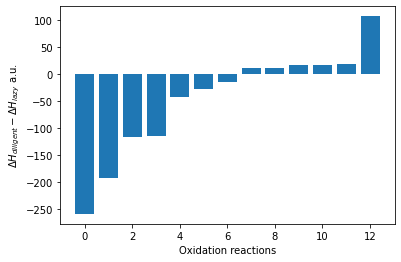

In [6]:
def visualize_diligent_vs_lazy(records, yunit="eV/atom"):
    nonzerodh_diff = []
    for i, record in enumerate(records):
        dh_old = record["dh_old"]
        dh_lazy = record["dh_lazy"]
        dh_diligent = record["dh_diligent"]
        if not is_close_to_zero(dh_diligent - dh_old):
            nonzerodh_diff.append(dh_diligent - dh_old)
    fig, ax = plt.subplots()
    ax.bar(range(len(nonzerodh_diff)), sorted(nonzerodh_diff))
    ax.set_xlabel("Oxidation reactions")
    ax.set_ylabel(r"$\Delta H_{diligent} - \Delta H_{lazy}$" + " {}".format(yunit))
    print("# of disagreements between lazy and diligent:", len(nonzerodh_diff), "/", len(records))
    print("# of better diligent:", len([diff for diff in nonzerodh_diff if diff < 0]))
    return fig

fig = visualize_diligent_vs_lazy(records_random_diligent_vs_lazy, yunit="a.u.")
fig.savefig("data/float/diligent_vs_lazy_random.eps")

From randomly generated oxidation reactions it is unclear if the *diligent* version is better than the *lazy* one.
But clearly these two implementations are different.


### Diligent vs lazy: MP dataset

In [7]:
# load the MP dataset as a list of (non_oxide, oxide_list), only stable compounds are included
# should take < 30s
mp_pairs = load_mp_oxide_pairs()

stable compounds: 67895


100%|██████████| 39654/39654 [00:17<00:00, 2266.22it/s]

# of pairs loaded: 39634


In [8]:
# run calculations if results are not saved
records_mpox_pkl = "data/part1/records_mpox.pkl"
if file_exists(records_mpox_pkl):
    records_mpox = pkl_load(records_mpox_pkl)
else:
    records_mpox = pqdm(mp_pairs, calculate_diligent_vs_lazy_oxides, n_jobs=8)  # took ~ 16 min
    pkl_dump(records_mpox, records_mpox_pkl)


loaded in: 6.1181 s


# of disagreements between lazy and diligent: 4091 / 39634
# of better diligent: 3219


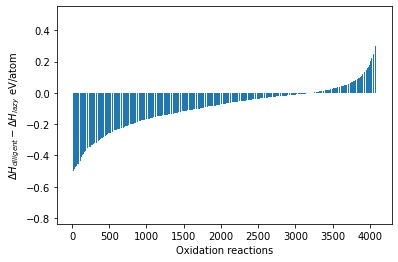

In [9]:
fig = visualize_diligent_vs_lazy(records_mpox, yunit="eV/atom")
fig.savefig("data/float/diligent_vs_lazy_mp.eps")

For MP dataset (39634 oxidation reactions), however, the *diligent* greedy algorithm does better than the *lazy* one (3219 *diligent* is better / 4091 disagreement cases).
